In [169]:
import sys, math, os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt    
import numpy as np
from scipy import stats


sys.path.insert(0, '../../src/data/')
import utils

%matplotlib inline
%load_ext autoreload  
%autoreload 2  

path_raw = "../../data/raw/beer_reviews"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Quick way of getting the notebook name, see [here](https://stackoverflow.com/a/23619544/1153897) for source; notebook name will be in python variable `notebook`.

In [170]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

# Introduction

The goal of this notebook is to try and answer the question
> Which brewery produces the strongest beers by ABV%?

**NOTE**: analysis [1.0_initial_look](1.0_initial_look.ipynb) identified that various attributes had missing data:
- `beer_abv` not available for all beers
- `brewery_name` not available for each `brewery_id` -> therefore, we should be grouping on `brewery_id`

# Potential issues

1. how to handle missing ABV%?
2. some breweries have only a single beer in this dataset; should we require a minimum number of beers?

In [171]:
# LOAD DATA
# we assume the file we're after is a
# single .csv in path_raw
for file in os.listdir(path_raw):
    file = os.path.join(path_raw, file)
    if os.path.isfile(file) and '.csv' in file: 
        dat_raw = pd.read_csv(file)
        
# DF of beer metadata
beer_meta_cols = ['brewery_id', 'brewery_name','beer_style', 'beer_name','beer_abv']
beer_dat = dat_raw.groupby('beer_beerid').agg('first')[beer_meta_cols]

<hr>

We being answering this required question based on the provided data, later we will model ABV%.

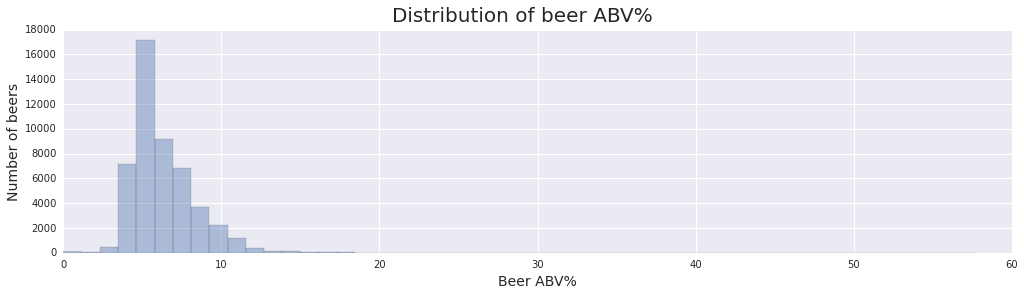

In [172]:
abv = beer_dat[beer_dat.beer_abv.notnull()].sort_values('beer_abv', ascending=False)
utils.draw_hist(abv.beer_abv.tolist(), 
                'Beer ABV%', 
                'Number of beers', 
                'Distribution of beer ABV%')

In [173]:
abv_stats = beer_dat[beer_dat.beer_abv.notnull()
                    ].groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
6513,10,4.9,57.7,24.690000,16.0
16315,89,0.5,41.0,9.301910,8.7
15237,46,2.0,39.0,10.130435,10.0
173,32,3.2,29.0,8.896875,10.0
35,97,4.0,27.0,7.641443,5.9


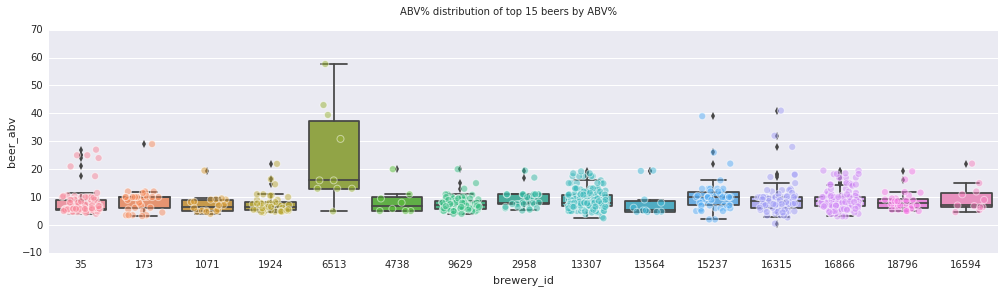

In [174]:
n = 15
top_breweries_by_abv = abv_stats.sort_values('max', ascending=False).index.tolist()[:15]

tmp = beer_dat[beer_dat.brewery_id.isin(top_breweries_by_abv)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s beers by ABV%%' %n)
# utils.autosave_fig(notebook)

Brewery 6513 seems a bit suspect...

# Remove outliers

For numerous breweries, there seem to be some outlier beers; let's remove outliers using the heuristic of IQR * 1.5

In [193]:
dats = []
for brewery_id, df in beer_dat[beer_dat.beer_abv.notnull()].groupby('brewery_id'):
    # remove any points outside of IQR * 1.5
    tmp = utils.remove_outliers(df.beer_abv)
    
    no_outliers = beer_dat.loc[tmp.index]
    dats.append(no_outliers)
    
without_outliers = pd.concat(dats)
print without_outliers.beer_abv.mean()

6.1832479883


In [176]:
abv_stats_no_outliers = without_outliers.groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats_no_outliers.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats_no_outliers.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
6513,10,4.90,57.7,24.690000,16.0
351,3,5.00,18.0,11.066667,10.2
10796,27,4.00,18.0,8.359259,6.2
11031,119,3.50,17.4,8.941597,9.2
2097,138,3.25,16.5,8.061957,7.1


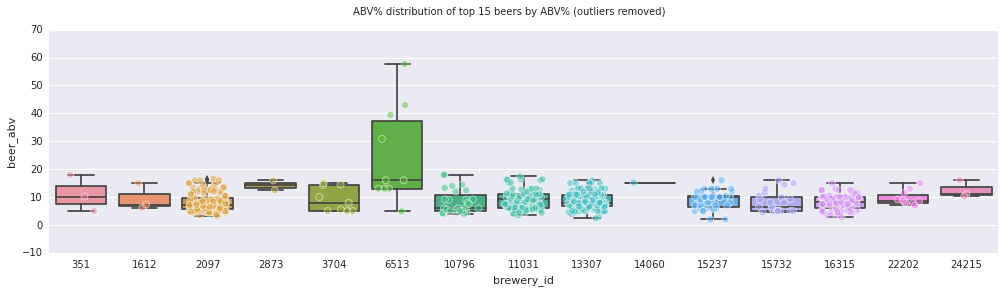

In [177]:
n = 15
top_breweries_by_abv_no_outliers = abv_stats_no_outliers.sort_values('max', ascending=False).index.tolist()[:n]

tmp = without_outliers[without_outliers.brewery_id.isin(top_breweries_by_abv_no_outliers)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s beers by ABV%% (outliers removed)' %n)
# utils.autosave_fig(notebook)

In [178]:
# let's bin the breweries by the number of beers they have in the dataset
# and check who has the highest ABV beer based on those bins
bins = 30
abv_stats_no_outliers.loc[:,'bin'] = pd.cut(abv_stats_no_outliers['count'], bins, labels=False)
bin_edges = {brewery_id:edges for brewery_id,edges in pd.cut(abv_stats_no_outliers['count'], bins, retbins=False).iteritems()}
best_per_group_no_outliers = []
for bin,dat in abv_stats_no_outliers.groupby('bin'):
    tmp = dat.sort_values('max', ascending=False)
    brewery_id = tmp.index.tolist()[0]
    best_per_group_no_outliers.append(brewery_id)
    abv = tmp['max'].tolist()[0]
    edges = bin_edges[brewery_id]
    print 'Brewery %s has highest ABV%% beer (%s) in group of breweries with %s beers available.' %(brewery_id, abv, edges)

Brewery 6513 has highest ABV% beer (57.7) in group of breweries with (0.5, 17.667] beers available.
Brewery 10796 has highest ABV% beer (18.0) in group of breweries with (17.667, 34.333] beers available.
Brewery 15237 has highest ABV% beer (16.0) in group of breweries with (34.333, 51] beers available.
Brewery 6288 has highest ABV% beer (15.0) in group of breweries with (51, 67.667] beers available.
Brewery 16315 has highest ABV% beer (15.0) in group of breweries with (67.667, 84.333] beers available.
Brewery 10099 has highest ABV% beer (14.0) in group of breweries with (84.333, 101] beers available.
Brewery 612 has highest ABV% beer (12.0) in group of breweries with (101, 117.667] beers available.
Brewery 11031 has highest ABV% beer (17.4) in group of breweries with (117.667, 134.333] beers available.
Brewery 2097 has highest ABV% beer (16.5) in group of breweries with (134.333, 151] beers available.
Brewery 13307 has highest ABV% beer (16.0) in group of breweries with (167.667, 184.3

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

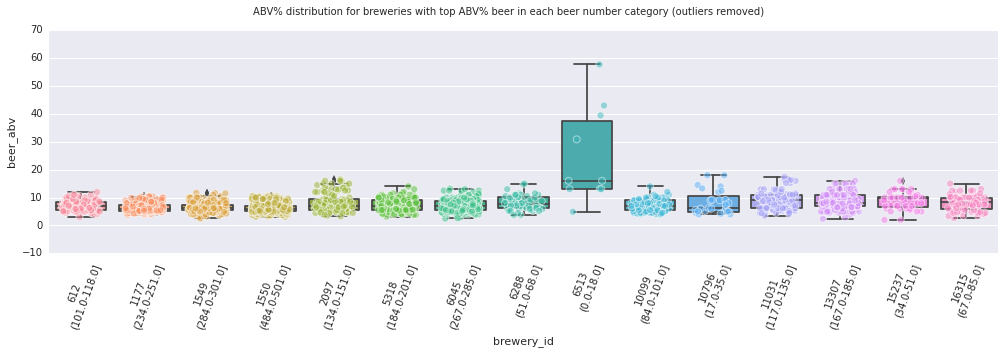

In [179]:
tmp = without_outliers[without_outliers.brewery_id.isin(best_per_group_no_outliers)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)

# add beer range for each bin
labels = [item.get_text() for item in ax.get_xticklabels()]
labels_clean = []
for l in labels:
    edges = bin_edges[int(l)].split(', ')
    low = math.floor(float(edges[0].replace('(','')))
    high = math.ceil(float(edges[1].replace(']','')))
    labels_clean.append(l + '\n(' + str(low) + '-' + str(high) + ']')
ax.set_xticklabels(labels_clean)

plt.suptitle('ABV% distribution for breweries with top ABV% beer in each beer number category (outliers removed)')
plt.xticks(rotation=70)
# utils.autosave_fig(notebook)

# Remove brewery 6513

In [180]:
without_6513 = without_outliers[without_outliers.brewery_id!=6513]
abv_stats_no_outliers_6513 = without_6513.groupby('brewery_id').agg(['count', 
                                                 'min',
                                                 'max',
                                                 'mean',
                                                 'median'])[['beer_abv']]
abv_stats_no_outliers_6513.columns = ['count','min','max','mean','median'] # get rid of multiindex on cols
abv_stats_no_outliers_6513.sort_values('max', ascending=False).head(5)

,count,min,max,mean,median
brewery_id,,,,,
351,3,5.00,18.0,11.066667,10.2
10796,27,4.00,18.0,8.359259,6.2
11031,119,3.50,17.4,8.941597,9.2
2097,138,3.25,16.5,8.061957,7.1
24215,3,10.30,16.1,12.466667,11.0


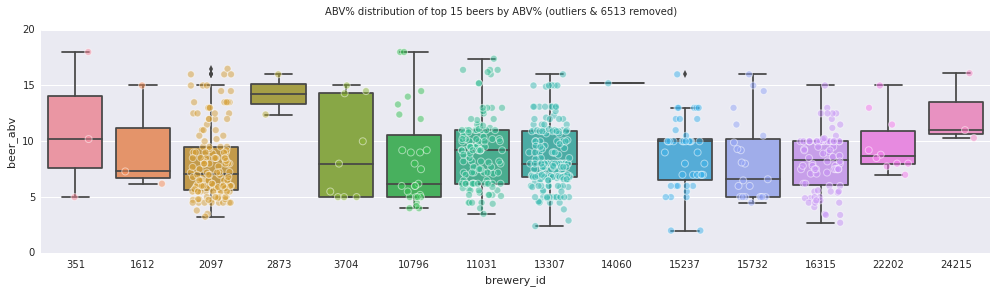

In [181]:
top_breweries_by_abv_no_outliers_6513 = abv_stats_no_outliers_6513.sort_values('max', ascending=False).index.tolist()[:10]

tmp = without_6513[without_6513.brewery_id.isin(top_breweries_by_abv_no_outliers)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)
plt.suptitle('ABV%% distribution of top %s beers by ABV%% (outliers & 6513 removed)' %n)
# utils.autosave_fig(notebook)

In [182]:
# let's bin the breweries by the number of beers they have in the dataset
# and check who has the highest ABV beer based on those bins
bins = 30
abv_stats_no_outliers_6513.loc[:,'bin'] = pd.cut(abv_stats_no_outliers_6513['count'], bins, labels=False)
bin_edges = {brewery_id:edges for brewery_id,edges in pd.cut(abv_stats_no_outliers_6513['count'], bins, retbins=False).iteritems()}
best_per_group_no_outliers_6513 = []
for bin,dat in abv_stats_no_outliers_6513.groupby('bin'):
    tmp = dat.sort_values('max', ascending=False)
    brewery_id = tmp.index.tolist()[0]
    best_per_group_no_outliers_6513.append(brewery_id)
    abv = tmp['max'].tolist()[0]
    edges = bin_edges[brewery_id]
    print 'Brewery %s has highest ABV%% beer (%s) in group of breweries with %s beers available.' %(brewery_id, abv, edges)

Brewery 351 has highest ABV% beer (18.0) in group of breweries with (0.5, 17.667] beers available.
Brewery 10796 has highest ABV% beer (18.0) in group of breweries with (17.667, 34.333] beers available.
Brewery 15237 has highest ABV% beer (16.0) in group of breweries with (34.333, 51] beers available.
Brewery 6288 has highest ABV% beer (15.0) in group of breweries with (51, 67.667] beers available.
Brewery 16315 has highest ABV% beer (15.0) in group of breweries with (67.667, 84.333] beers available.
Brewery 10099 has highest ABV% beer (14.0) in group of breweries with (84.333, 101] beers available.
Brewery 612 has highest ABV% beer (12.0) in group of breweries with (101, 117.667] beers available.
Brewery 11031 has highest ABV% beer (17.4) in group of breweries with (117.667, 134.333] beers available.
Brewery 2097 has highest ABV% beer (16.5) in group of breweries with (134.333, 151] beers available.
Brewery 13307 has highest ABV% beer (16.0) in group of breweries with (167.667, 184.33

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

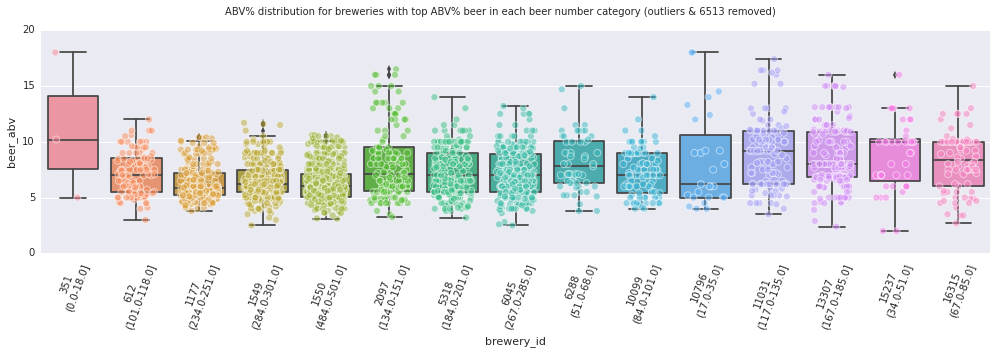

In [183]:
tmp = without_6513[without_6513.brewery_id.isin(best_per_group_no_outliers_6513)]

plt.figure(figsize=(17,4))
ax = sns.boxplot(x="brewery_id", y="beer_abv", data=tmp)
ax = sns.stripplot(x="brewery_id", y="beer_abv", data=tmp, jitter=0.3, alpha=0.5)

# add beer range for each bin
labels = [item.get_text() for item in ax.get_xticklabels()]
labels_clean = []
for l in labels:
    edges = bin_edges[int(l)].split(', ')
    low = math.floor(float(edges[0].replace('(','')))
    high = math.ceil(float(edges[1].replace(']','')))
    labels_clean.append(l + '\n(' + str(low) + '-' + str(high) + ']')
ax.set_xticklabels(labels_clean)

plt.suptitle('ABV% distribution for breweries with top ABV% beer in each beer number category (outliers & 6513 removed)')
plt.xticks(rotation=70)
# utils.autosave_fig(notebook)

11031/2097 looks like a good contender for most strong beers

In [189]:
utils.remove_outliers(beer_dat.beer_abv).index

Int64Index([    5,     6,     7,     8,     9,    10,    11,    12,    13,
               14,
            ...
            77306, 77307, 77308, 77309, 77310, 77312, 77313, 77314, 77315,
            77316],
           dtype='int64', name=u'beer_beerid', length=47250)